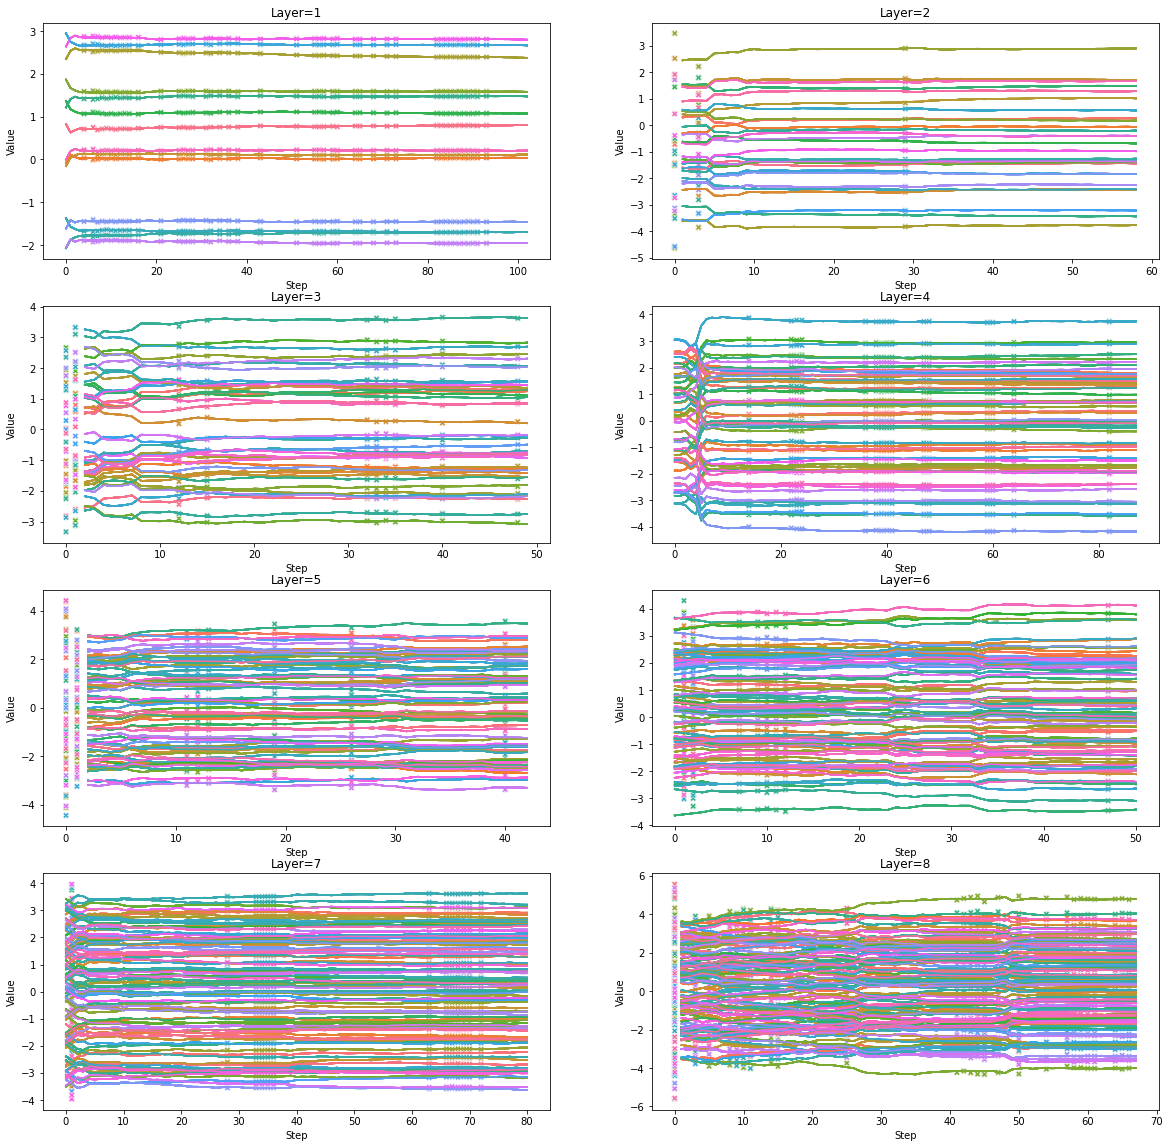

In [40]:
%matplotlib inline
import dill
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
for l in range(1, 9):
    for i in range(16):
        with open(f'./Ciruit3_2/reps={l}/{1}/storage', 'rb') as f:
            storage = dill.load(f)
        storage.plot_params(ax=axes.flatten()[l-1], method='mpl')
        axes.flatten()[l-1].get_legend().remove()
        axes.flatten()[l-1].set_title(f"Layer={l}")

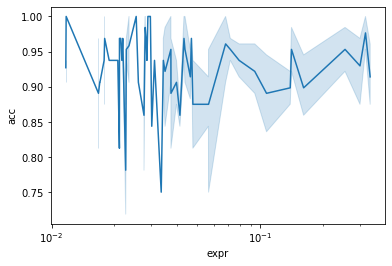

In [50]:
import numpy as np
from pandas import read_csv
import pandas as pd
import seaborn as sns

data = read_csv('./Ciruit3_2/result.csv')
sns.lineplot(data=data, x='expr', y='acc')
plt.xscale('log')

In [51]:
expr = data['expr'].to_numpy()
acc = data['acc'].to_numpy()

Text(0.5, 1.0, 'Circuit #3')

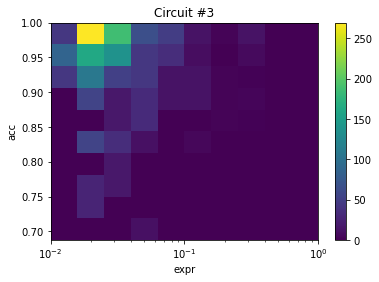

In [138]:
xedge = 10**(np.linspace(-2, 0, 11))
yedge = np.linspace(0.8, 1, 11)
plt.hist2d(x=expr, y=acc, bins=[xedge, 10], density=True)
plt.xscale('log')
plt.colorbar()
plt.xlabel('expr')
plt.ylabel('acc')
plt.title('Circuit #3')

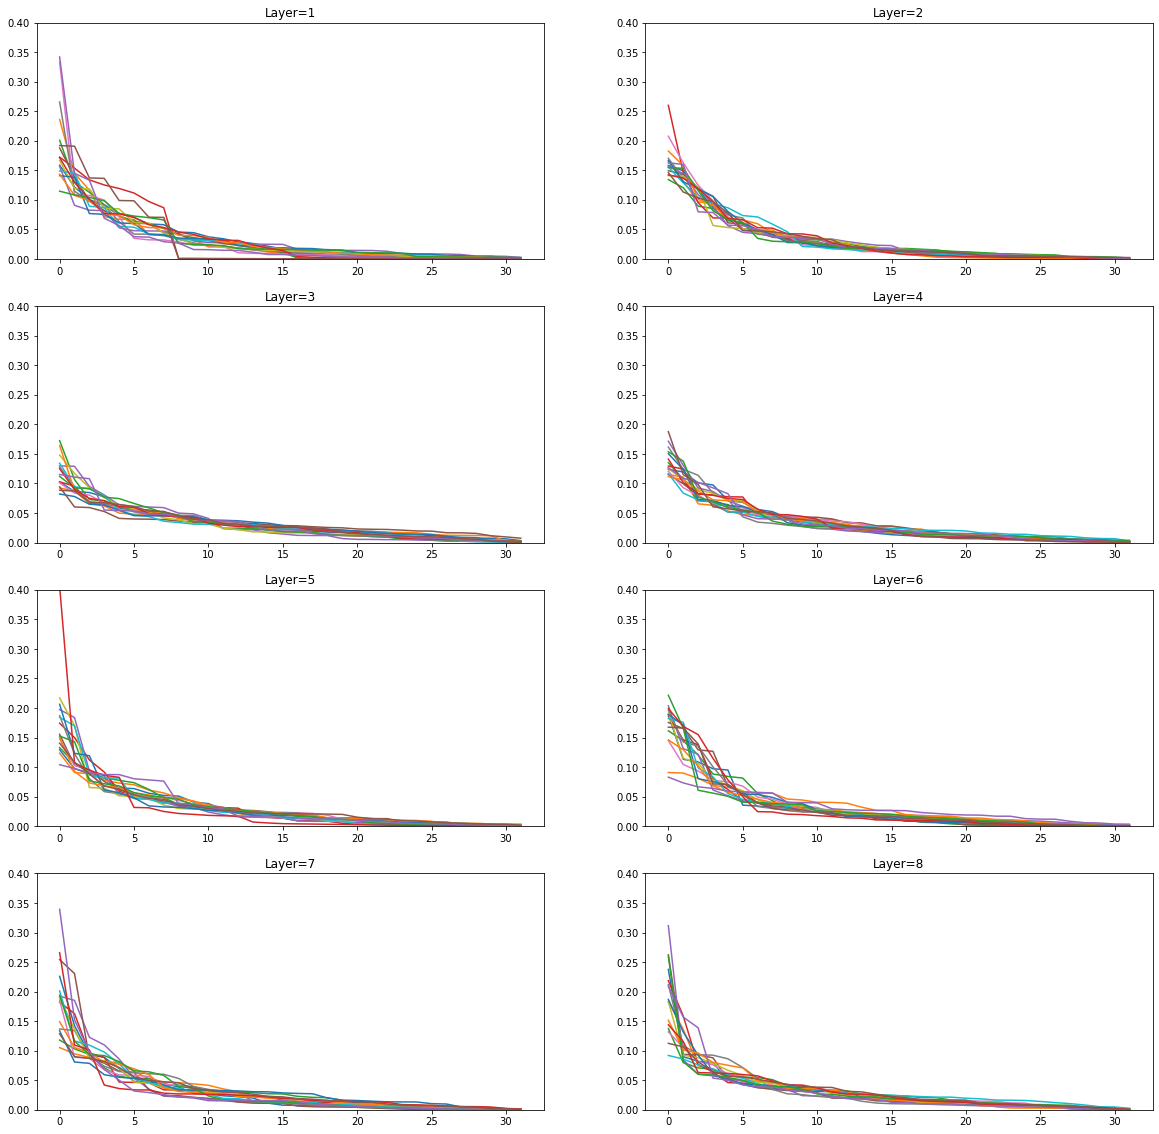

In [120]:
%matplotlib inline
import dill
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 2, figsize=(20, 20))
for l in range(1, 9):
    for i in range(16):
        with open(f'./Ciruit3_iris_data/reps={l}/{i}/nqsvm', 'rb') as f:
            nqsvm = dill.load(f)
        var_form = nqsvm.var_form
        var_qc = var_form.assign_parameters(dict(zip(var_form.parameters, list(nqsvm.parameters))))
        var_qc.save_statevector()
        result = nqsvm.quantum_instance.execute(var_qc)
        alpha = np.abs(result.get_statevector()) ** 2

        axes.flatten()[l-1].plot(sorted(alpha, reverse=True))
        axes.flatten()[l-1].set_ylim([0, .4])
    axes.flatten()[l-1].set_title(f"Layer={l}")


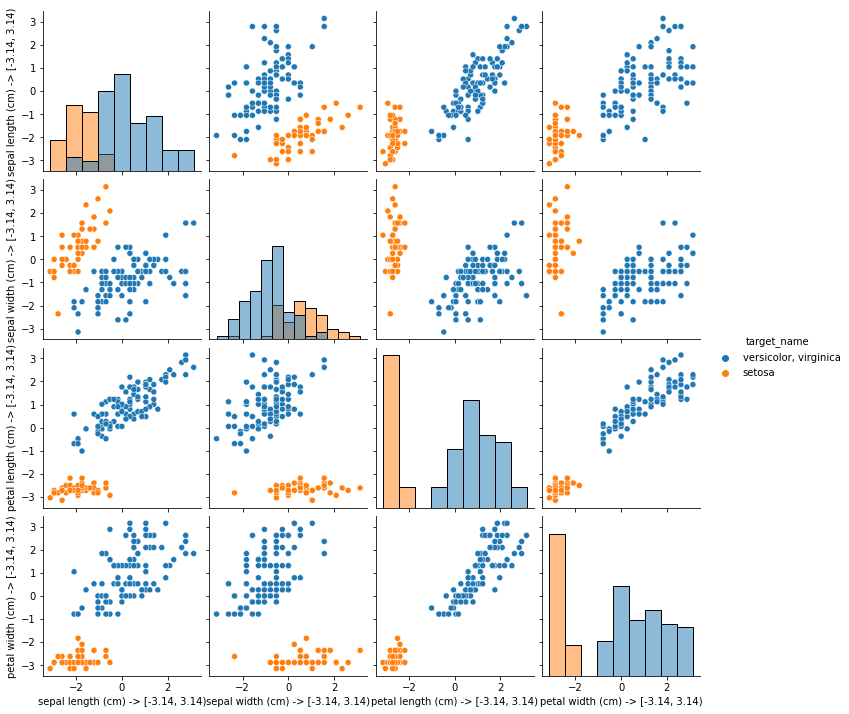

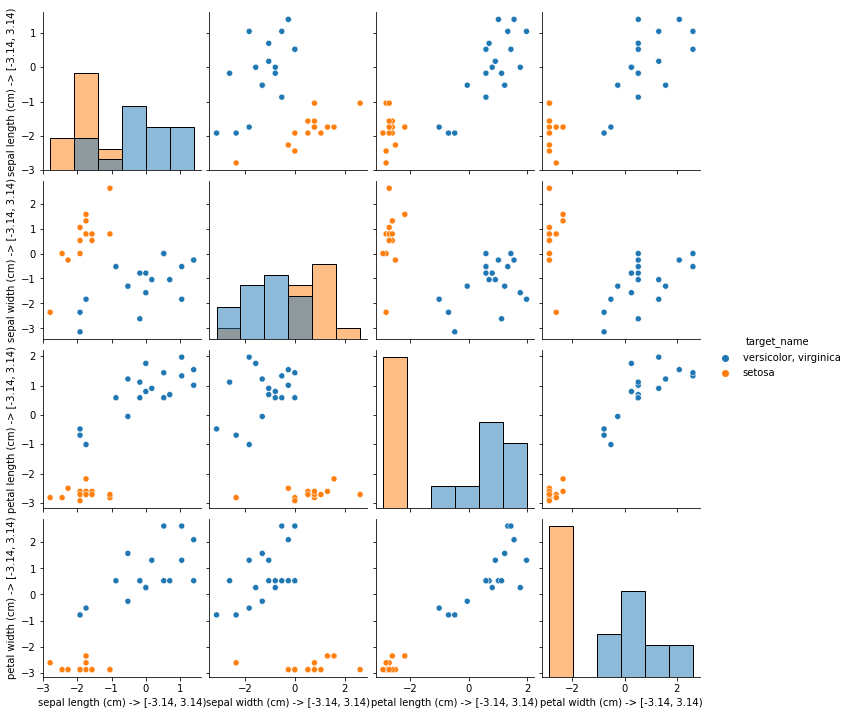

In [1]:
%matplotlib inline
import numpy as np
from classifiers.datasets import IrisDataset
ds = IrisDataset(feature_range=(-np.pi, np.pi), true_hot=0)
ds.plot()
X, y = ds.sample(2**5, return_X_y=True)
ds.plot((X, y))

In [2]:
from classifiers.quantum.qasvm import NormQSVM, PseudoNormQSVM
from classifiers.quantum.ansatz import sample_circuit, Circuit9
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage

from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap

In [3]:
sCircuit = sample_circuit(3)
var_form = sCircuit(5, reps=1)
_tmp = Circuit9(4, reps=1)
feature_map = _tmp.copy()
feature_map.compose(_tmp, inplace=True)
feature_map.compose(_tmp, inplace=True)
quantum_instance = QuantumInstance(AerSimulator(), shots=2**15)
nqsvm = NormQSVM(X, y, quantum_instance, var_form=var_form, feature_map=feature_map)


In [4]:
from tqdm.notebook import tqdm
storage = CostParamStorage()
optimizer = tSPSA(callback=storage)
MAXITER = 2**10
LAST_AVG = 2**4
for epoch in tqdm(range(2*MAXITER)):
    optimizer.step(nqsvm.cost_fn, nqsvm.parameters)
    if storage.num_accepted() > 2 * LAST_AVG and storage.last_cost_std(2 * LAST_AVG, ignore_rejected=True) < \
            storage.last_cost_std(LAST_AVG, ignore_rejected=True):
        break

  0%|          | 0/2048 [00:00<?, ?it/s]

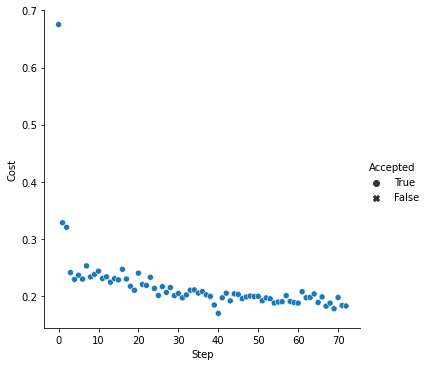

In [5]:
nqsvm.parameters = storage.last_avg(LAST_AVG)
storage.plot()

In [6]:
Xt, yt = ds.sample(2**5, return_X_y=True)
nqsvm.accuracy(Xt, yt)

0.9375

In [7]:
nqsvm = NormQSVM(X, y, quantum_instance, var_form=var_form, feature_map=feature_map)
storage = CostParamStorage()
optimizer = tSPSA(callback=storage)
MAXITER = 2**10
LAST_AVG = 2**4
for epoch in tqdm(range(2*MAXITER)):
    optimizer.step(nqsvm.cost_fn, nqsvm.parameters)
    if storage.num_accepted() > 2 * LAST_AVG and storage.last_cost_std(2 * LAST_AVG, ignore_rejected=True) < \
            storage.last_cost_std(LAST_AVG, ignore_rejected=True):
        break
nqsvm.parameters = storage.last_avg(LAST_AVG)
nqsvm.accuracy(Xt, yt)

  0%|          | 0/2048 [00:00<?, ?it/s]

0.96875

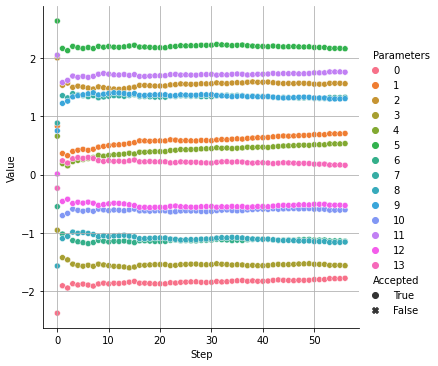

In [7]:
storage.plot_params()

In [47]:
from pandas import read_csv, DataFrame
import seaborn as sns
import numpy as np
df = read_csv('./Ciruit3_iris_data/result.csv')
result = df.pivot_table(index=['num_params', 'layers'], values=['expr', 'entcap', 'acc', 'last_cost', 'num_iter'], aggfunc=np.mean)
result

,,acc,entcap,expr,last_cost,num_iter
num_params,layers,,,,,
14.0,1.0,0.925781,0.178033,0.363397,0.203159,86.1250
28.0,2.0,0.978516,0.353243,0.146706,0.152796,74.3750
42.0,3.0,0.949219,0.463677,0.079912,0.115094,56.9375
56.0,4.0,0.947266,0.544408,0.045063,0.106916,59.6875
70.0,5.0,0.902344,0.595430,0.037869,0.164997,62.7500
84.0,6.0,0.875000,0.643601,0.043037,0.137596,65.0625
98.0,7.0,0.748047,0.681415,0.014006,0.126404,73.0625
112.0,8.0,0.802734,0.706456,0.021958,0.135570,73.0625


In [48]:
data1 = np.array(list(result.index))
data2 = result.to_numpy()
if len(data1.shape)==1:
    data1 = data1.reshape(-1, 1)
data = np.hstack([data1, data2])

In [49]:
result_df = DataFrame(data=data, columns=list(result.index.names) + list(result.columns))
result_df

,num_params,layers,acc,entcap,expr,last_cost,num_iter
0,14.0,1.0,0.925781,0.178033,0.363397,0.203159,86.1250
1,28.0,2.0,0.978516,0.353243,0.146706,0.152796,74.3750
2,42.0,3.0,0.949219,0.463677,0.079912,0.115094,56.9375
3,56.0,4.0,0.947266,0.544408,0.045063,0.106916,59.6875
4,70.0,5.0,0.902344,0.595430,0.037869,0.164997,62.7500
5,84.0,6.0,0.875000,0.643601,0.043037,0.137596,65.0625
6,98.0,7.0,0.748047,0.681415,0.014006,0.126404,73.0625
7,112.0,8.0,0.802734,0.706456,0.021958,0.135570,73.0625


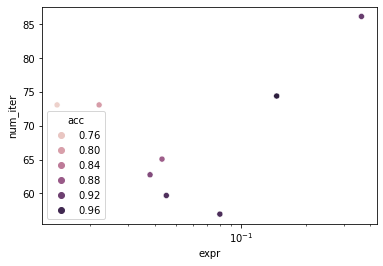

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.scatterplot(data=result_df, x='expr', y='num_iter', hue='acc')
plt.xscale('log')

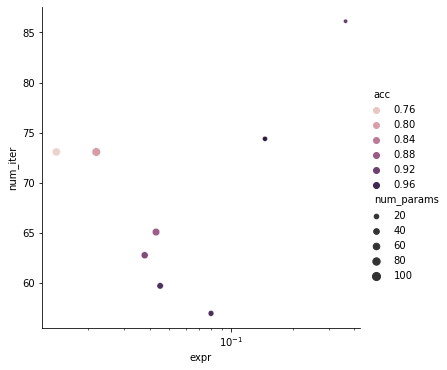

In [61]:
sns.relplot(data=result_df, x='expr', y='num_iter', hue='acc', size='num_params')
plt.xscale('log')

In [52]:
data1 = data1.reshape(-1, 1)

Text(0.5, 0, 'num_iter')

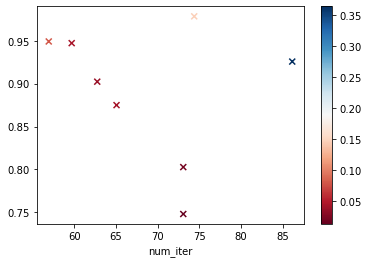

In [54]:
plt.scatter(x=result_df['num_iter'], y=result_df['acc'], marker='x', c=result_df['expr'], cmap='RdBu')
plt.colorbar()
plt.xlabel('num_iter')

FileNotFoundError: [Errno 2] No such file or directory: './aaa'

array([[0.36339667, 0.14670601, 0.07991238, 0.04506254, 0.03786897,
        0.04303679, 0.01400619, 0.02195836],
       [0.36339667, 0.14670601, 0.07991238, 0.04506254, 0.03786897,
        0.04303679, 0.01400619, 0.02195836],
       [0.36339667, 0.14670601, 0.07991238, 0.04506254, 0.03786897,
        0.04303679, 0.01400619, 0.02195836],
       [0.36339667, 0.14670601, 0.07991238, 0.04506254, 0.03786897,
        0.04303679, 0.01400619, 0.02195836],
       [0.36339667, 0.14670601, 0.07991238, 0.04506254, 0.03786897,
        0.04303679, 0.01400619, 0.02195836],
       [0.36339667, 0.14670601, 0.07991238, 0.04506254, 0.03786897,
        0.04303679, 0.01400619, 0.02195836],
       [0.36339667, 0.14670601, 0.07991238, 0.04506254, 0.03786897,
        0.04303679, 0.01400619, 0.02195836],
       [0.36339667, 0.14670601, 0.07991238, 0.04506254, 0.03786897,
        0.04303679, 0.01400619, 0.02195836]])